In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns

import mantrap
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 100)

import os
import sys
trajectron_path = "third_party/GenTrajectron/code"
module_path = mantrap.utility.io.build_os_path(trajectron_path, make_dir=False, free=False)
sys.path.insert(0, module_path)

In [9]:
data_files = [f"eval_data/{f}" for f in os.listdir("eval_data") if f.endswith(".pkl")]
eval_df = pd.concat([pd.read_pickle(d) for d in data_files], sort=True)

eval_df["warm_start"] = eval_df["warm_start"].fillna("default")
eval_df.drop(columns=["attention", "env", "eval_env", "solver", "modules", "goal"], inplace=True)

eval_df = eval_df[eval_df.solver_name != "orca"]  # too few data points
eval_df.head()

,ado_effort,attention_name,directness,ego_effort,env_name,eval_env_name,extra_time,final_distance,max_cpu_time,minimal_distance,modules_name,num_ados,runtime[s],scenario,solver_name,solver_type,warm_start
0,8.962074,none,0.985848,1.216366,trajectron,same,-0.4,0.044430,0.5,0.704050,default,10.0,0.449392,0.0,rrt_star,<class 'mantrap.solver.baselines.rrt_star.RRTS...,default
1,6.826923,none,0.857816,1.136420,trajectron,same,-0.4,0.252193,0.5,0.097097,default,10.0,0.455112,0.0,rrt_star,<class 'mantrap.solver.baselines.rrt_star.RRTS...,default
2,7.102613,none,0.964779,1.197627,trajectron,same,-0.4,0.050727,0.5,0.711039,default,10.0,0.478234,0.0,rrt_star,<class 'mantrap.solver.baselines.rrt_star.RRTS...,default
9,8.741807,none,0.972934,1.218413,trajectron,same,-0.4,0.067703,1.0,0.527368,default,10.0,0.441837,0.0,rrt_star,<class 'mantrap.solver.baselines.rrt_star.RRTS...,default
10,8.118806,none,0.724858,1.242104,trajectron,same,-0.4,0.326753,1.0,0.731913,default,10.0,0.445969,0.0,rrt_star,<class 'mantrap.solver.baselines.rrt_star.RRTS...,default


In [10]:
eval_df.shape

(728, 17)

In [11]:
metric_cols = ["ado_effort", "ego_effort", "directness", "final_distance", "minimal_distance", "runtime[s]"]

## Build scenario/method combinations

In [12]:
eval_df["scene"] = eval_df.apply(lambda row: f"{row.env_name}(num_ados={int(row.num_ados)}, scenario={int(row.scenario)})", axis=1)
eval_df.drop(columns=["scenario"], inplace=True)
eval_df = eval_df.rename(columns={"num_ados": "# humans"})

In [13]:
our_approach = "ipopt/default"
our_method = "Ours"

approaches = ["mcts/default", "rrt_star/default", "ipopt/ellipsoidal", our_approach]
methods = ["MCTS", "RRT*", "Decoupled", our_method]
methods_wo = [m for m in methods if m != our_method]

eval_df["method"] = eval_df.apply(lambda row: f"{row.solver_name}/{row.modules_name}", axis=1)
eval_df["method"] = eval_df["method"].replace(approaches, methods)
eval_df = eval_df[eval_df.method != "ipopt/inter_pos"]
eval_df.drop(columns=["modules_name"], inplace=True)

## Visualization of evaluation results

In [14]:
def compare(col: str, col_groupby: str, comp_method: str, df: pd.DataFrame):
    our_median_dict = df[df["method"] == comp_method].groupby(col_groupby)[col].median().to_dict()
    return df.apply(lambda row: (row[col]/our_median_dict[row[col_groupby]] - 1) * 100, axis=1)

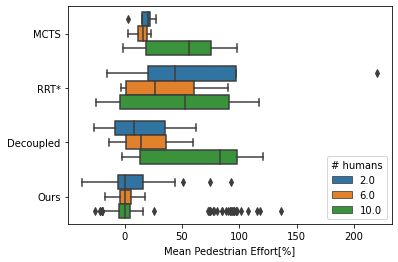

In [15]:
box_df = eval_df[["ado_effort", "method", "# humans", "scene"]].copy()
box_df[f"ado_effort[%]"] = compare("ado_effort", col_groupby="scene", comp_method=our_method, df=box_df)

sns.boxplot("ado_effort[%]", y="method", hue="# humans", order=methods, data=box_df)

plt.xlabel("Mean Pedestrian Effort[%]")
plt.ylabel("")

plt.gcf().subplots_adjust(left=0.15)
plt.savefig("ado_effort.png", dpi=300, bbox_inches='tight')
plt.show()

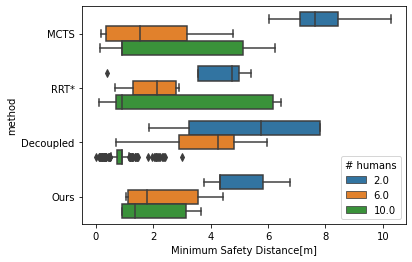

In [9]:
box_df = eval_df[["minimal_distance", "method", "# humans", "scene"]].copy()

sns.boxplot("minimal_distance", y="method", hue="# humans", order=methods, data=box_df)
plt.xlabel("Minimum Safety Distance[m]")

plt.gcf().subplots_adjust(left=0.15)
plt.savefig("minimal_distance.png", dpi=300, bbox_inches='tight')
plt.show()

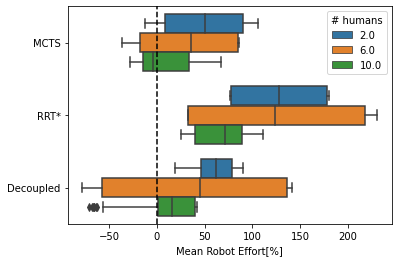

In [10]:
box_df = eval_df[["ego_effort", "method", "# humans", "scene"]].copy()
box_df[f"ego_effort[%]"] = compare("ego_effort", col_groupby="scene", comp_method=our_method, df=box_df)

box_df = box_df[box_df["method"] != our_method]
sns.boxplot("ego_effort[%]", y="method", hue="# humans", order=methods_wo, data=box_df)
plt.axvline(x=0, color="k", linestyle='--')
plt.xlabel("Mean Robot Effort[%]")
plt.ylabel("")

plt.gcf().subplots_adjust(left=0.15)
plt.savefig("ego_effort.png", dpi=300, bbox_inches='tight')
plt.show()

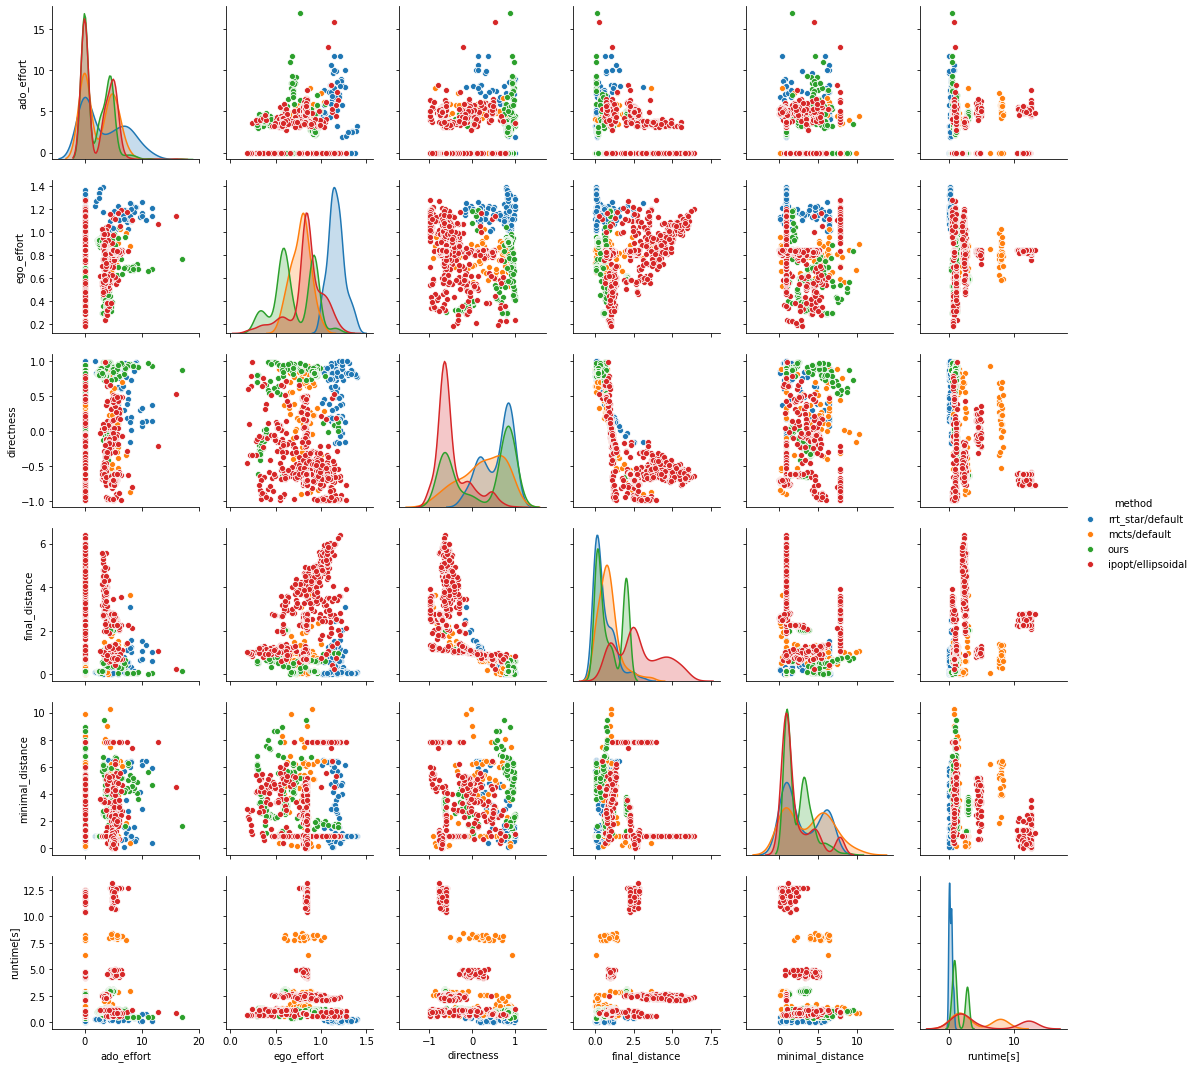

In [25]:
sns.pairplot(hue="method", data=eval_df[metric_cols + ["method"]])
plt.show()

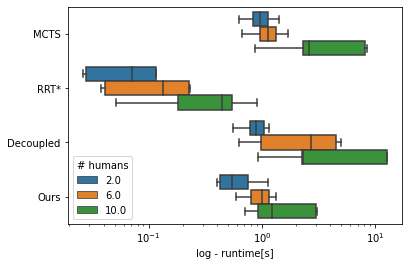

In [13]:
sns.boxplot("runtime[s]", y="method", hue="# humans", order=methods, data=eval_df)
plt.xscale("log")
plt.xlabel("log - runtime[s]")
plt.ylabel("")
plt.savefig("runtime.png", dpi=300, bbox_inches='tight')
plt.show()